### 버전 기록_ DUMMY
- Model Baseline 코드 (2024.12.30)
- Drug Graph, Drug Graph Embedding Block 추가 (2025.01.01)
- Dummy Data로 교체 (25.01.02)
- Train, Valid, Test 추가 (25.01.02)
- Pathway Graph, Pathway Graph Embedding Block 추가 (2025.01.03)
- 연산 최적화 (모델 내 for문 제거, 텐서 연산 활용) (2025.01.05)
- Cross Attention 유효 임베딩으로만 사용 (2025.01.08)
- SingleHeadDifferentialCrossAttn 추가 (2025.01.09)
- Pathway 별 Substructure Cross Attention로 수정 (2025.01.10)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn.functional as F
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"CUDA is available: {torch.cuda.is_available()}")

CUDA is available: False


In [3]:
import psutil
import os

process = psutil.Process(os.getpid())

# 2. Dataset

In [4]:
class DrugResponseDataset(Dataset):
    def __init__(self, gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs, labels, sample_indices):
        """
        Args:
            gene_embeddings (dict): {cell_line_id: Tensor}, Gene embeddings for each cell line.
            drug_graphs (dict): List of PyTorch Geometric Data objects for each drug (indexed by drug_id).
            substructure_embeddings (Tensor): [245, 193], Substructure embeddings for pathways.
            labels (dict): {cell_line_id: Tensor}, Drug response labels for each cell line and drug pair.
            sample_indices (list): [(cell_line_id, drug_idx)], List of cell line and drug index pairs.
        """
        self.gene_embeddings = gene_embeddings  # {cell_line_id: [245, 231]}
        self.pathway_graphs = pathway_graphs
        self.drug_graphs = drug_graphs  # Drug graphs
        self.substructure_embeddings = substructure_embeddings  # [170]
        self.labels = labels  # {cell_line_id, drug_id : [1]}
        self.sample_indices = sample_indices  # [(cell_line_id, drug_id)]


    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        cell_line_id, drug_id = self.sample_indices[idx]

        # Gene embeddings for the cell line
        gene_embedding = self.gene_embeddings[cell_line_id]  # [245, 231]
        pathway_graph = self.pathway_graphs  # Pathway graphs

        # Substructure embeddings for pathways
        substructure_embedding = self.substructure_embeddings[drug_id]  # [1, 170]
        drug_graph = self.drug_graphs[drug_id]  # Drug graphs

        # Get the label for the cell line-drug pair
        label = self.labels[cell_line_id, drug_id]  # Scalar

        return {
            'gene_embedding': gene_embedding,  # [245, 231]
            'pathway_graph': pathway_graph,                     # List of PyTorch Geometric Data objects
            'substructure_embedding': substructure_embedding,  # [245, 170]
            'drug_graph': drug_graph,  # PyTorch Geometric Data object
            'label': label  # Scalar
        }

In [5]:

def collate_fn(batch):
    gene_embeddings = []
    substructure_embeddings = []
    drug_graphs = []
    labels = []
    
    for item in batch:
        gene_embeddings.append(item['gene_embedding'])
        substructure_embeddings.append(item['substructure_embedding'])
        drug_graphs.append(item['drug_graph'])
        labels.append(item['label'])

    pathway_graph = batch[0]['pathway_graph'] 
    pathway_batch = Batch.from_data_list(pathway_graph)
    drug_batch = Batch.from_data_list(drug_graphs)

    return {
        'gene_embeddings': torch.stack(gene_embeddings),  # [batch_size, num_pathways, num_genes]
        'pathway_graphs': pathway_batch,  
        'substructure_embeddings': torch.stack(substructure_embeddings),  # [batch_size, num_pathways, num_substructures]
        'drug_graphs': drug_batch, # PyTorch Geometric Batch
        'labels': torch.tensor(labels, dtype=torch.float32)  # [batch_size]
    }

In [6]:
# 각 데이터셋 초기화
train_data = torch.load('dataset/train_dataset.pt')
train_dataset = DrugResponseDataset(
    gene_embeddings=train_data['gene_embeddings'],
    pathway_graphs=train_data['pathway_graphs'],  # 공유되는 데이터
    substructure_embeddings=train_data['substructure_embeddings'],
    drug_graphs=train_data['drug_graphs'],
    labels=train_data['labels'],
    sample_indices=train_data['sample_indices'],
)

val_data = torch.load('dataset/train_dataset.pt')
val_dataset = DrugResponseDataset(
    gene_embeddings=val_data['gene_embeddings'],
    pathway_graphs=val_data['pathway_graphs'],  # 공유되는 데이터
    substructure_embeddings=val_data['substructure_embeddings'],
    drug_graphs=val_data['drug_graphs'],
    labels=val_data['labels'],
    sample_indices=val_data['sample_indices'],
)

# DataLoader 초기화
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

# 데이터 확인
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Train set size: 56
Validation set size: 56


In [7]:
# 데이터 확인
for batch in train_loader:
    print(f"Batch gene embeddings: {batch['gene_embeddings'].shape}")  # [batch_size, num_pathways, num_genes]
    print(f"Batch pathway_graphs: {batch['pathway_graphs']}")  
    print(f"Batch substructure embeddings: {batch['substructure_embeddings'].shape}")   # [batch_size, num_pathways, num_substructures]
    print(f"Batch drug graphs: {batch['drug_graphs']}")  # PyTorch Geometric Batch
    print(f"Batch labels: {batch['labels'].shape}")  # [batch_size]
    break

Batch gene embeddings: torch.Size([8, 5, 15])
Batch pathway_graphs: DataBatch(x=[75, 128], edge_index=[2, 75], global_ids=[5], batch=[75], ptr=[6])
Batch substructure embeddings: torch.Size([8, 12])
Batch drug graphs: DataBatch(x=[96, 5], edge_index=[2, 96], global_ids=[8], batch=[96], ptr=[9])
Batch labels: torch.Size([8])


# 3. Model

## (0) Embedding Layer
### - GeneEmbeddingLayer : FloatTensor -> Linear
### - SubstructureEmbeddingLayer : IntTensor -> nn.Embedding

In [8]:
class GeneEmbeddingLayer(nn.Module):
    # In)  [BATCH_SIZE, NUM_PATHWAYS, NUM_GENES] 
    # Out) [BATCH_SIZE, NUM_PATHWAYS, NUM_GENES, GENE_EMBEDDING_DIM]

    def __init__(self, num_pathways, num_genes, embedding_dim):
        super(GeneEmbeddingLayer, self).__init__()
        self.linear = nn.Linear(1, embedding_dim)  
        self.num_pathways = num_pathways
        self.num_genes = num_genes
        self.embedding_dim = embedding_dim
        
    def forward(self, gene_values):
        gene_values = gene_values.view(-1, 1) # [BATCH_SIZE * NUM_PATHWAYS * NUM_GENES, 1]
        embedded_values = self.linear(gene_values)  # [BATCH_SIZE * NUM_PATHWAYS * NUM_GENES, GENE_EMBEDDING_DIM]
        return embedded_values.view(-1, self.num_pathways, self.num_genes, self.embedding_dim) 

class SubstructureEmbeddingLayer(nn.Module):
    # In)  [BATCH_SIZE, NUM_SUBSTRUCTURES]
    # Out) [BATCH_SIZE, NUM_SUBSTRUCTURES, SUBSTRUCTURES_EMBEDDING_DIM]
    
    def __init__(self, num_substructures, embedding_dim):
        super(SubstructureEmbeddingLayer, self).__init__()
        self.embedding = nn.Embedding(num_substructures, embedding_dim) # [NUM_SUBSTRUCTURES, SUBSTRUCTURES_EMBEDDING_DIM]

    def forward(self, substructure_indices):
        return self.embedding(substructure_indices) 

## (1) SingleHeadDifferCrossAttention

In [9]:
import math
from DiffTransformer.rms_norm import RMSNorm

def lambda_init_fn(depth):
    return 0.8 - 0.6 * math.exp(-0.3 * depth)

class SingleHeadDifferCrossAttn(nn.Module):
    def __init__(self, embed_dim: int, depth: int = 0):
        super().__init__()
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // 2
        self.scaling = self.head_dim ** -0.5

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)  # (E -> E)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)  # (E -> E)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)  # (E -> E)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)

        self.lambda_init = lambda_init_fn(depth)

        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim).normal_(mean=0, std=0.1))

        self.subln = RMSNorm(2 * self.head_dim, eps=1e-5, elementwise_affine=True)

    def forward(self, gene: torch.Tensor, substructure: torch.Tensor) -> torch.Tensor:
        bsz, n_gene, _ = gene.size()
        _, n_sub,  _ = substructure.size()

        # 1) Q, K, V 구하기 (Cross Attention)
        q = self.q_proj(gene)              # (B, n_gene, E)
        k = self.k_proj(substructure)      # (B, n_sub,  E)
        v = self.v_proj(substructure)      # (B, n_sub,  E)

        # 2) Q, K -> [2, head_dim], V -> [2 * head_dim]
        q = q.view(bsz, n_gene, 2, self.head_dim)   # (B, n_gene, 2, head_dim)
        k = k.view(bsz, n_sub,  2, self.head_dim)   # (B, n_sub,  2, head_dim)
        v = v.view(bsz, n_sub,  2 * self.head_dim)  # (B, n_sub,  2 * head_dim)

        # 3) matmul 위해 transpose (slot 차원을 두 번째로)
        q = q.transpose(1, 2)  # (B, 2, n_gene, head_dim)
        k = k.transpose(1, 2)  # (B, 2, n_sub,  head_dim)
        v = v.unsqueeze(1)     # (B, 1, n_sub, 2*head_dim)

        q = q * self.scaling

        # 4) attention score = Q @ K^T
        #    => (B, 2, n_gene, head_dim) x (B, 2, head_dim, n_sub) = (B, 2, n_gene, n_sub)
        attn_weights = torch.matmul(q, k.transpose(-1, -2))  # (B, 2, n_gene, n_sub)
        attn_weights = F.softmax(attn_weights, dim=-1)  # (B, 2, n_gene, n_sub)

        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1))
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1))
        lambda_full = lambda_1 - lambda_2 + self.lambda_init

        # 5) 두 슬롯(0, 1) 간 차이를 내어 최종 attn_weights 계산
        diff_attn = attn_weights[:, 0] - lambda_full * attn_weights[:, 1]  # (B, n_gene, n_sub)
        diff_attn = diff_attn.unsqueeze(1)  # (B, 1, n_gene, n_sub)

        attn_output = torch.matmul(diff_attn, v)
        attn_output = self.subln(attn_output)               # (B, 1, n_gene, 2*head_dim)
        attn_output = attn_output * (1.0 - self.lambda_init)
        attn_output = attn_output.squeeze(1)                # (B, n_gene, 2*head_dim)
        out = self.out_proj(attn_output)                    # (B, n_gene, E)

        return out


## (2) Graph Embedding

In [10]:
class PathwayGraphEmbedding(nn.Module):
    def __init__(self, batch_size, input_dim, hidden_dim):
        super(PathwayGraphEmbedding, self).__init__()
        self.batch_size = batch_size
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, gene_emb, pathway_graph):
        """
        Args:
            gene_emb: Tensor of shape [BATCH_SIZE, NUM_GENES, 128]
            pathway_graph: PyTorch Geometric Data object (single graph)
        Returns:
            graph_embeddings: Tensor of shape [BATCH_SIZE, NUM_PATHWAYS, EMBEDDING_DIM]
        """
        # Repeat the graph `batch_size` times (데이터 자체에서 graph를 복사해서 넣어주면 삭제 가능하나 메모리 상황 보고 결정)
        repeated_graphs = [pathway_graph.clone() for _ in range(self.batch_size)]
        batched_graph = Batch.from_data_list(repeated_graphs)
        expected_nodes = batched_graph.x.size(0)
        # print(f"Expected Nodes: {expected_nodes}, Gene Emb Shape: {gene_emb.shape}")

        # Update node features for all graphs
        node_features = gene_emb  # Shape: [BATCH_SIZE, NUM_NODES, 128]
        node_features = gene_emb.view(-1, gene_emb.size(-1))  # Shape: [BATCH_SIZE * NUM_VALID_NODES, 128]
        assert node_features.size(0) == expected_nodes, \
            f"Node feature count mismatch: {node_features.size(0)} != {expected_nodes}"

        batched_graph.x = node_features  # Assign to graph

        # GCN layers
        x = F.relu(self.conv1(batched_graph.x, batched_graph.edge_index))
        x = self.conv2(x, batched_graph.edge_index)

        # Global mean pooling to aggregate graph embeddings
        graph_embeddings = global_mean_pool(x, batched_graph.batch)  # Shape: [BATCH_SIZE, EMBEDDING_DIM]
        
        return graph_embeddings


class DrugGraphEmbedding(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DrugGraphEmbedding, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

    def forward(self, drug_graph, drug_graph_embedding):
        """
        Args:
            drug_graph (Batch): Batched PyTorch Geometric Data object.
            drug_graph_embedding (Tensor): [BATCH_SIZE, NUM_PATHWAYS, NUM_SUBSTRUCTURES, EMBEDDING_DIM]
        """
        all_node_features = []
        updated_node_features = torch.mean(drug_graph_embedding, dim=1)  # [BATCH_SIZE, NUM_SUBSTRUCTURES, SUBSTRUCTURE_EMBEDDING_DIM]

        # Batch Loop
        for batch_idx in range(updated_node_features.size(0)):  
            # Get global IDs and node indices
            global_ids = drug_graph[batch_idx].global_ids  
            node_indices = torch.where(drug_graph.batch == batch_idx)[0]

            # Ensure global_ids and node_indices match in length
            assert len(global_ids) == len(node_indices), "Mismatch between global IDs and node indices length"

            # Update node features for the current batch
            node_features = torch.zeros((len(node_indices), updated_node_features.size(-1)), device=updated_node_features.device)
            for local_idx, global_id in enumerate(global_ids):
                if global_id < updated_node_features.size(1):
                    node_features[local_idx] = updated_node_features[batch_idx, global_id]

            # Append the current batch's node features to the list
            all_node_features.append(node_features)

        # updated node features from all batches
        new_node_features = torch.cat(all_node_features, dim=0)  # Shape: [TOTAL_NUM_NODES, EMBEDDING_DIM]
        drug_graph.x = new_node_features

        # GCN layers
        x = self.conv1(drug_graph.x, drug_graph.edge_index)
        x = F.relu(x)
        x = self.conv2(x, drug_graph.edge_index)

        # Perform global mean pooling
        graph_embedding = global_mean_pool(x, drug_graph.batch)  # Shape: [BATCH_SIZE, HIDDEN_DIM]
        
        return graph_embedding




## (3) DrugResponseModel

In [11]:
import torch
import torch.nn as nn

class DrugResponseModel(nn.Module):
    def __init__(self, num_pathways, num_genes, num_substructures, gene_dim, substructure_dim, hidden_dim, final_dim, output_dim, batch_size, depth):
        super(DrugResponseModel, self).__init__()
        self.gene_embedding_layer = GeneEmbeddingLayer(num_pathways, num_genes, gene_dim)
        self.substructure_embedding_layer = SubstructureEmbeddingLayer(num_substructures, substructure_dim)
        
        self.Gene2Sub_cross_attention = SingleHeadDifferCrossAttn(gene_dim, depth)
        self.Sub2Gene_cross_attention = SingleHeadDifferCrossAttn(substructure_dim, depth)

        self.pathway_graph = PathwayGraphEmbedding(batch_size ,gene_dim, hidden_dim)
        self.drug_graph = DrugGraphEmbedding(substructure_dim, hidden_dim)

        self.fc1 = nn.Linear(gene_dim + hidden_dim, final_dim)
        self.fc2 = nn.Linear(final_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs):
        # Gene and Substructure Embeddings
        substructure_embeddings = substructure_embeddings.int()  
        gene_embeddings = self.gene_embedding_layer(gene_embeddings)  # [Batch, Pathway, Gene, Embedding_dim]
        substructure_embeddings = self.substructure_embedding_layer(substructure_embeddings)  # [Batch, Substructure, Embedding_dim]

        pathway_graph_embeddings = []
        drug_embeddings = []

        # Pathway Cross Attention & Graph Embedding
        for i in range(len(pathway_graphs)):
            pathway_graph = pathway_graphs[i]

            # 유효한 gene 필터링
            valid_gene_indices = pathway_graph['global_ids']  # [Num_Valid_Genes]
            filtered_gene_embeddings = gene_embeddings[:, i, valid_gene_indices, :]  # [Batch, Num_Valid_Genes, Embedding_dim]

            # Cross Attention
            gene_attention_out = self.Gene2Sub_cross_attention(
                filtered_gene_embeddings,  # [Batch, Num_Valid_Genes, Embedding_dim]
                substructure_embeddings  # [Batch, Num_Substructures, Embedding_dim]
            )  # [Batch, Num_Valid_Genes, Embedding_dim]

            sub_attention_out = self.Sub2Gene_cross_attention(
                substructure_embeddings, # [Batch, Num_Substructures, Embedding_dim]
                filtered_gene_embeddings # [Batch, Num_Valid_Genes, Embedding_dim]
            )

            # Pathway Graph Embedding
            graph_embedding = self.pathway_graph(gene_attention_out, pathway_graph)

            pathway_graph_embeddings.append(graph_embedding)
            drug_embeddings.append(sub_attention_out)
        
        pathway_graph_embedding = torch.stack(pathway_graph_embeddings, dim=1) # [Batch, Num_Pathways, Embedding_dim]]
        drug_embeddings = torch.stack(drug_embeddings, dim = 1)

        # Drug Graph Embedding
        drug_embeddings = torch.mean(drug_embeddings, dim = 1)
        drug_graph_embedding = self.drug_graph(drug_graphs, drug_embeddings)  # [Batch, hidden_dim]

        # Final Embedding
        final_pathway_embedding = torch.mean(pathway_graph_embedding, dim=1)  # [Batch, Embedding_dim]
        final_drug_embedding = drug_graph_embedding

        # Concatenate and Predict
        combined_embedding = torch.cat((final_pathway_embedding, final_drug_embedding), dim=-1)  # [B, Dg + H]

        x = self.fc1(combined_embedding)
        x = self.fc2(x)

        return self.sigmoid(x)


# 4. Initialization

In [12]:
NUM_CELL_LINES = 10
NUM_PATHWAYS = 5
NUM_GENES = 15
NUM_DRUGS = 7
NUM_SUBSTRUCTURES = 12

GENE_EMBEDDING_DIM = 128
SUBSTRUCTURE_EMBEDDING_DIM = 128
HIDDEN_DIM = 128
FINAL_DIM = 64
OUTPUT_DIM = 1
BATCH_SIZE = 8
DEPTH = 1


model = DrugResponseModel(NUM_PATHWAYS, NUM_GENES, NUM_SUBSTRUCTURES, GENE_EMBEDDING_DIM, SUBSTRUCTURE_EMBEDDING_DIM, HIDDEN_DIM, FINAL_DIM, OUTPUT_DIM, BATCH_SIZE, DEPTH)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model device: {next(model.parameters()).device}")
print(f"CUDA is available: {torch.cuda.is_available()}")

Model device: cpu
CUDA is available: False


# 5. Train

In [13]:
# Training Loop with Validation and Metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 1

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0
    correct_train_preds = 0
    total_train_samples = 0

    for batch in train_loader:
        gene_embeddings = batch['gene_embeddings'].to(device)
        pathway_graphs =  batch['pathway_graphs'].to(device)
        substructure_embeddings = batch['substructure_embeddings'].to(device)
        drug_graphs = batch['drug_graphs'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Accuracy Calculation
        preds = (outputs.squeeze() > 0.5).long()  # Binary classification threshold
        correct_train_preds += (preds == labels).sum().item()
        total_train_samples += labels.size(0)

    train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_samples
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct_val_preds = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            gene_embeddings = batch['gene_embeddings'].to(device)
            pathway_graphs =  batch['pathway_graphs'].to(device)
            substructure_embeddings = batch['substructure_embeddings'].to(device)
            drug_graphs = batch['drug_graphs'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs)
            loss = criterion(outputs.squeeze(), labels)
            total_val_loss += loss.item()

            # Accuracy Calculation
            preds = (outputs.squeeze() > 0.5).long()
            correct_val_preds += (preds == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss = total_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_samples
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  torch.Size([8, 5, 15])
substructure embeddings :  torch.Size([8, 12])
gene embeddings :  to

# 6. Test

In [14]:
# # Test Phase
# model.eval()
# total_test_loss = 0
# correct_test_preds = 0
# total_test_samples = 0

# with torch.no_grad():
#     for batch in test_loader:
#         gene_embeddings = batch['gene_embeddings'].to(device)
#         pathway_graphs =  batch['pathway_graphs'].to(device)
#         substructure_embeddings = batch['substructure_embeddings'].to(device)
#         drug_graphs = batch['drug_graphs'].to(device)
#         labels = batch['labels'].to(device)

#         # Forward pass
#         outputs = model(gene_embeddings, pathway_graphs, substructure_embeddings, drug_graphs)
#         loss = criterion(outputs.squeeze(), labels)
#         total_test_loss += loss.item()

#         # Accuracy Calculation
#         preds = (outputs.squeeze() > 0.5).long()  # Binary classification threshold
#         correct_test_preds += (preds == labels).sum().item()
#         total_test_samples += labels.size(0)

# test_loss = total_test_loss / len(test_loader)
# test_accuracy = correct_test_preds / total_test_samples

# print("\nTest Results:")
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


# 7. Results

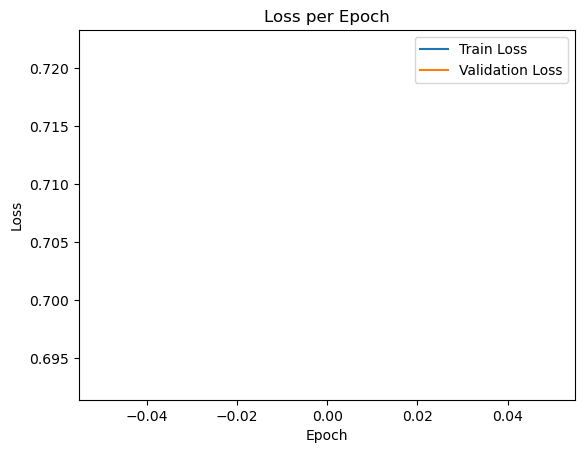

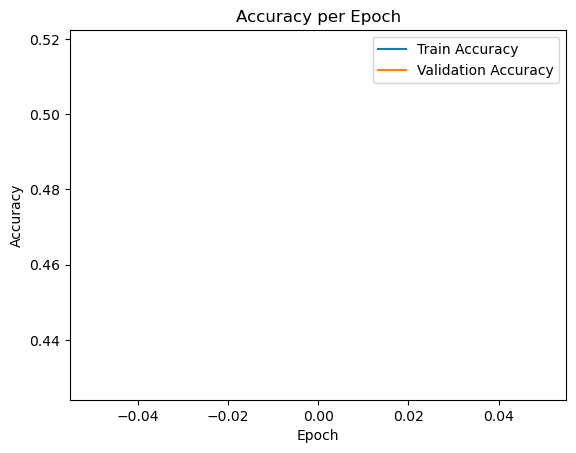

In [15]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

# Plot Train and Validation Accuracy
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')
plt.show()